<a href="https://colab.research.google.com/github/JotaBlanco/Creditos_MyInvestor/blob/main/Simulaci%C3%B3n_Cr%C3%A9ditos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01 - Import

In [218]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

# 02 - Import SP500

In [219]:
df_1 = pd.read_csv("https://raw.githubusercontent.com/JotaBlanco/Creditos_MyInvestor/main/data/SP500_1.csv")
df_1 = df_1[["Date", "Close"]]
df_1.columns = ["Date", "SP500"]
df_1["Date"] = pd.to_datetime(df_1["Date"])
df_1["SP500"] = df_1["SP500"].astype(float)
df_1

,Date,SP500
0,1950-01-03,16.660000
1,1950-01-04,16.850000
2,1950-01-05,16.930000
3,1950-01-06,16.980000
4,1950-01-09,17.080000
...,...,...
17213,2018-05-31,2705.270020
17214,2018-06-01,2734.620117
17215,2018-06-04,2746.870117
17216,2018-06-05,2748.800049


In [220]:
def convert_to_float(str_i):
  try:
    return float(str_i)
  except:
    return np.NaN

df_2 = pd.read_csv("https://raw.githubusercontent.com/JotaBlanco/Creditos_MyInvestor/main/data/SP500_2.csv")
df_2.columns = ["Date", "SP500"]
df_2["Date"] = pd.to_datetime(df_2["Date"])
df_2["SP500"] = [convert_to_float(str_i) for str_i in df_2["SP500"]]
df_2["SP500"] = df_2["SP500"].fillna(method='backfill')
df_2

,Date,SP500
0,2014-03-28,1857.62
1,2014-03-31,1872.34
2,2014-04-01,1885.52
3,2014-04-02,1890.90
4,2014-04-03,1888.77
...,...,...
2604,2024-03-21,5241.53
2605,2024-03-22,5234.18
2606,2024-03-25,5218.19
2607,2024-03-26,5203.58


In [221]:
df = pd.concat([df_1, df_2[df_2["Date"]>df_1["Date"].iloc[-1]]]).reset_index(drop=True)
df

,Date,SP500
0,1950-01-03,16.66
1,1950-01-04,16.85
2,1950-01-05,16.93
3,1950-01-06,16.98
4,1950-01-09,17.08
...,...,...
18728,2024-03-21,5241.53
18729,2024-03-22,5234.18
18730,2024-03-25,5218.19
18731,2024-03-26,5203.58


In [222]:
df_monthly = df.set_index("Date").resample("M").last().reset_index()
df_weekly = df.set_index("Date").resample("w").last().reset_index()

In [223]:
df["perc_max"] = df["SP500"]/df["SP500"].cummax()
df_weekly["perc_max"] = df_weekly["SP500"]/df_weekly["SP500"].cummax()
df_monthly["perc_max"] = df_monthly["SP500"]/df_monthly["SP500"].cummax()
df

,Date,SP500,perc_max
0,1950-01-03,16.66,1.000000
1,1950-01-04,16.85,1.000000
2,1950-01-05,16.93,1.000000
3,1950-01-06,16.98,1.000000
4,1950-01-09,17.08,1.000000
...,...,...,...
18728,2024-03-21,5241.53,1.000000
18729,2024-03-22,5234.18,0.998598
18730,2024-03-25,5218.19,0.995547
18731,2024-03-26,5203.58,0.992760


# 03 - Quick analysis

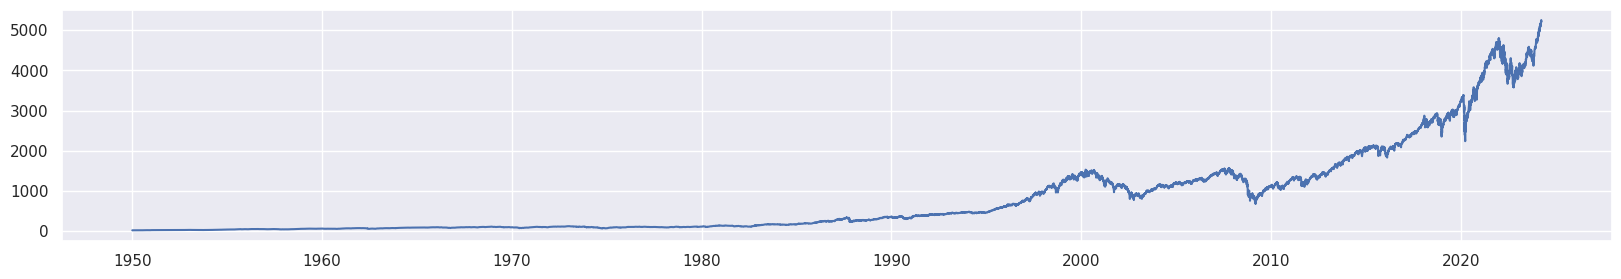

In [224]:
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(df["Date"], df["SP500"], label="daily")
plt.show()

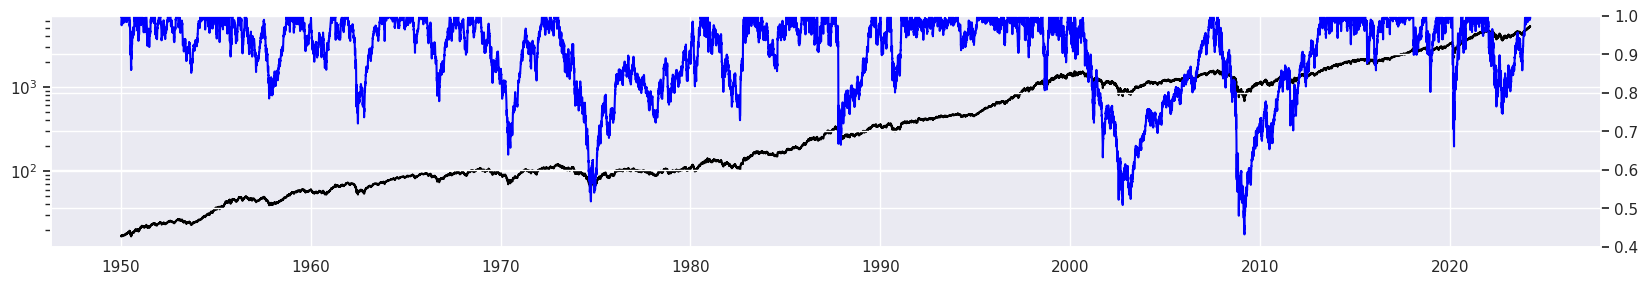

In [225]:
# Creating plot with dataset_1
fig, ax1 = plt.subplots()

ax1.plot(df["Date"], df["SP500"], label="daily", color = "black")

# Adding Twin Axes to plot using dataset_2
ax2 = ax1.twinx()
ax2.plot(df["Date"], df["perc_max"], color = "blue")

#ax1.set_ylim(bottom=0, top=6000)
ax2.set_ylim(bottom=0.4, top=1)
ax1.set_yscale('log')
plt.show()

In [228]:
df["perc_max"].describe()

count    18733.000000
mean         0.903230
std          0.104844
min          0.432246
25%          0.844977
50%          0.944205
75%          0.985503
max          1.000000
Name: perc_max, dtype: float64

In [229]:
np.quantile(df["perc_max"], 0.05)

0.6949404015726482

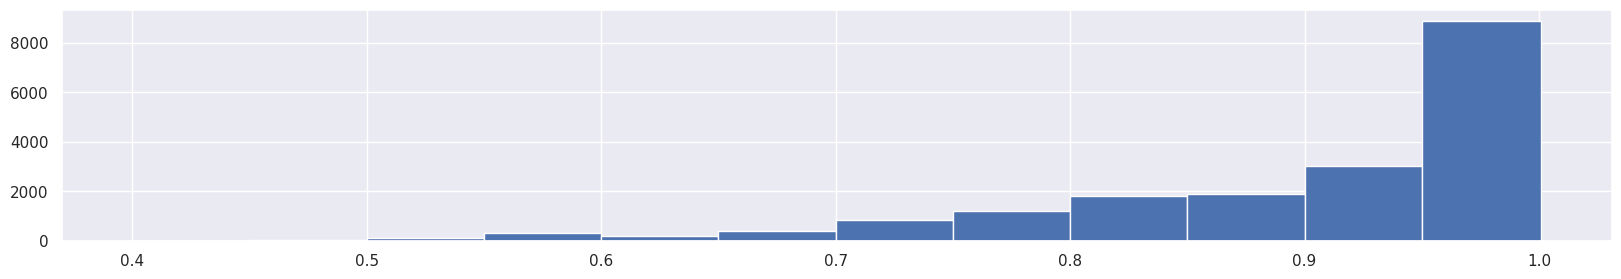

In [230]:
plt.hist(df["perc_max"], bins=[0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.001])
plt.show()

# 04 - Strategies
Functions with different investment strategies

In [348]:
def simulate(df_ingresos:pd.DataFrame, df_monthly:pd.DataFrame):
  df = df_monthly.copy(deep=True)
  df = pd.concat([df, df_ingresos[["ingresos", "coste", "ingresos_ac", "coste_ac"]]], axis=1)
  df = df.dropna(subset=["ingresos"])
  df["growth"] = df["SP500"]/df["SP500"].shift(1).fillna(1)
  total = 0
  for i in range(len(df)):
    total = df.loc[i, "ingresos"] + total*df.loc[i, "growth"]
    df.loc[i, "total"] = total
  df["total"] = df["total"].astype(int)
  df["total_neto"] = df["total"]
  filter_i = df["total"] > df["ingresos_ac"]
  df.loc[filter_i,"total_neto"] = df.loc[filter_i,"ingresos_ac"] + (1-0.23)*(df.loc[filter_i,"total"]-df.loc[filter_i,"ingresos_ac"])
  return df

def get_simulation_summary(df_sim:pd.DataFrame):
  df_summary = pd.DataFrame({
      "Date_0": [df_sim["Date"].iloc[0]],
      "Date_n": [df_sim["Date"].iloc[-1]],
      "perc_max_0": [df_sim["perc_max"].iloc[0]],
      "ingresos_ac": [int(df_sim["ingresos_ac"].iloc[-1])],
      "coste_ac": [int(df_sim["coste_ac"].iloc[-1])],
      "total_bruto": [int(df_sim["total"].iloc[-1])],
      "total_neto": [int(df_sim["total_neto"].iloc[-1])]
  })
  return df_summary

def get_intereses_trimestrales(capital):
  df_intereses = pd.DataFrame({
      "Importe": [10000, 20000, 30000, 40000, 50000, 60000, 75000, 100000],
      "Int_trimestales": [102.5, 205, 307.5, 410, 512.5, 615, 768.75, 1025]
      })
  df_intereses = pd.concat([df_intereses, pd.DataFrame({"Importe": [capital], "Int_trimestales": [np.NaN]})])
  df_intereses = df_intereses.set_index("Importe").sort_index()
  df_intereses = df_intereses.interpolate(method="index")
  try:
    return df_intereses.loc[capital,"Int_trimestales"].iloc[0]
  except:
    return df_intereses.loc[capital,"Int_trimestales"]

In [349]:
coste_anual_deseado = 12000
años = 15

recurrente = coste_anual_deseado/12
months = 12*años
loan_amount = recurrente*12*5/1.205

def estrategia_1(recurrent_amount, months):
  df = pd.DataFrame({
      "coste": [recurrent_amount]*months,
      "ingresos": [recurrent_amount]*months})
  df["coste_ac"] = df["coste"].cumsum()
  df["ingresos_ac"] = df["ingresos"].cumsum()
  return df

def estrategia_2(recurrent_amount, months):
  loan_amount = recurrent_amount*12*5/1.205
  int_trimestral = get_intereses_trimestrales(loan_amount)
  lista_costes = [int_trimestral,0,0]*(4*5)
  lista_costes[-1] = lista_costes[-1] + loan_amount
  lista_costes = lista_costes + [recurrent_amount]*(months-12*5)
  lista_ingresos = [loan_amount] + [0]*(12*5-1) + [recurrent_amount]*(months-12*5)
  df = pd.DataFrame({"coste": lista_costes, "ingresos": lista_ingresos})
  df["coste_ac"] = df["coste"].cumsum()
  df["ingresos_ac"] = df["ingresos"].cumsum()
  return df

def estrategia_3(recurrent_amount, months):
  loan_amount = recurrent_amount*12*5/1.205
  int_trimestral = get_intereses_trimestrales(loan_amount)
  lista_costes = [recurrent_amount]*months
  lista_costes_intereses = [int_trimestral,0,0]*(months//3)
  lista_ingresos = np.array(lista_costes)-np.array(lista_costes_intereses)
  lista_ingresos[0] = lista_ingresos[0] + loan_amount
  df = pd.DataFrame({"coste": lista_costes, "ingresos": lista_ingresos})
  df["coste_ac"] = df["coste"].cumsum()
  df["ingresos_ac"] = df["ingresos"].cumsum()
  return df

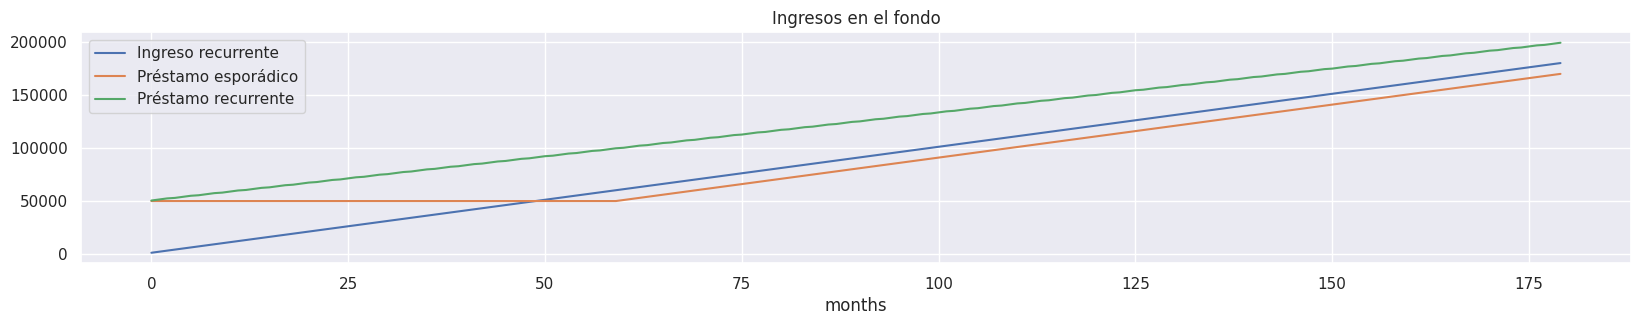

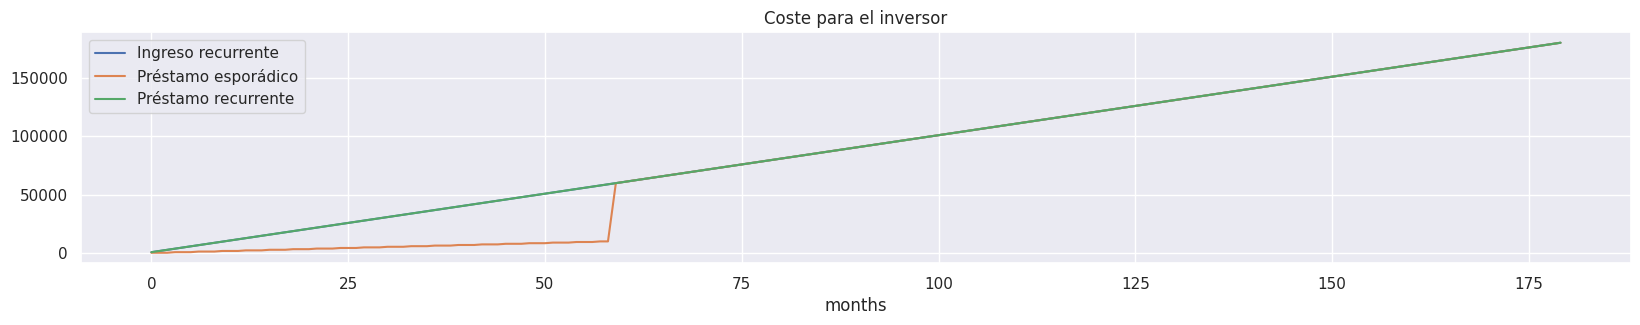

In [350]:
# 1
plt.plot(estrategia_1(recurrente, months)["ingresos_ac"], label="Ingreso recurrente")
plt.plot(estrategia_2(recurrente, months)["ingresos_ac"], label="Préstamo esporádico")
plt.plot(estrategia_3(recurrente, months)["ingresos_ac"], label="Préstamo recurrente")
plt.legend()
plt.title("Ingresos en el fondo")
plt.xlabel("months")
plt.show()

# 2
plt.plot(estrategia_1(recurrente, months)["coste_ac"], label="Ingreso recurrente")
plt.plot(estrategia_2(recurrente, months)["coste_ac"], label="Préstamo esporádico")
plt.plot(estrategia_3(recurrente, months)["coste_ac"], label="Préstamo recurrente")
plt.legend()
plt.title("Coste para el inversor")
plt.xlabel("months")
plt.show()

# 05 - Simulations

In [414]:
coste_anual_deseado = 12000
años = 15

recurrente = coste_anual_deseado/12
months = 12*años
loan_amount = recurrente*12*5/1.205

df_1 = estrategia_1(recurrente, months)
df_2 = estrategia_2(recurrente, months)
df_3 = estrategia_3(recurrente, months)

In [421]:
def perform_sim(años, coste_anual_deseado):

  recurrente = coste_anual_deseado/12
  months = 12*años
  loan_amount = recurrente*12*5/1.205

  df_1 = estrategia_1(recurrente, months)
  df_2 = estrategia_2(recurrente, months)
  df_3 = estrategia_3(recurrente, months)

  df_all_sim = pd.DataFrame()
  for i in range(len(df_monthly)-12*años):
    df_montly_i = df_monthly.iloc[i:i+12*años]

    df_1_i = get_simulation_summary(simulate(df_1, df_montly_i.reset_index(drop=True)))
    df_1_i.columns = ['Date_0', 'Date_n', 'perc_max_0',
                      'ingresos_ac_1', 'coste_ac_1', 'total_bruto_1', 'total_neto_1']

    df_2_i = get_simulation_summary(simulate(df_2, df_montly_i.reset_index(drop=True)))
    df_2_i.columns = ['Date_0', 'Date_n', 'perc_max_0',
                      'ingresos_ac_2', 'coste_ac_2', 'total_bruto_2', 'total_neto_2']

    df_3_i = get_simulation_summary(simulate(df_3, df_montly_i.reset_index(drop=True)))
    df_3_i.columns = ['Date_0', 'Date_n', 'perc_max_0',
                      'ingresos_ac_3', 'coste_ac_3', 'total_bruto_3', 'total_neto_3']

    df_i = pd.merge(df_1_i, df_2_i, how="left", on=["Date_0","Date_n","perc_max_0"])
    df_i = pd.merge(df_i, df_3_i, how="left", on=["Date_0","Date_n","perc_max_0"])

    df_all_sim = pd.concat([df_all_sim, df_i], axis=0).reset_index(drop=True)

  df_all_sim["total_neto_3"] = df_all_sim["total_neto_3"] - loan_amount
  df_all_sim["total_neto_3"] = df_all_sim["total_neto_3"].astype(int)
  return df_all_sim


def plot_results(años, df_ii):
  display(df_ii.describe())
  plt.rcParams["figure.figsize"] = (10,5)
  p = sns.kdeplot(data=df_ii[["total_neto_1","total_neto_2","total_neto_3"]])
  ticks = max(p.get_yticks())  # get the max value of the y-ticks
  p.vlines(x=np.mean(df_ii["coste_ac_1"].iloc[-1]) , ymin=0, ymax=ticks, color='red')
  plt.xlim(left=min(df_ii["total_neto_3"]), right=max(df_ii["total_neto_3"]))
  plt.title(str(años)+" AÑOS")
  plt.show()
  print()

  filter_i = df_ii["perc_max_0"] < 0.8
  df_iii = df_ii[filter_i]
  display(df_iii.describe())
  plt.rcParams["figure.figsize"] = (10,5)
  p = sns.kdeplot(data=df_iii[["total_neto_1","total_neto_2","total_neto_3"]])
  ticks = max(p.get_yticks())  # get the max value of the y-ticks
  p.vlines(x=np.mean(df_iii["coste_ac_1"].iloc[-1]) , ymin=0, ymax=ticks, color='red')
  plt.xlim(left=min(df_iii["total_neto_3"]), right=max(df_iii["total_neto_3"]))
  plt.title(str(años)+" AÑOS only investing under 0.8")
  plt.show()
  print()

  filter_i = df_ii["perc_max_0"] < 0.7
  df_iii = df_ii[filter_i]
  display(df_iii.describe())
  plt.rcParams["figure.figsize"] = (10,5)
  p = sns.kdeplot(data=df_iii[["total_neto_1","total_neto_2","total_neto_3"]])
  ticks = max(p.get_yticks())  # get the max value of the y-ticks
  p.vlines(x=np.mean(df_iii["coste_ac_1"].iloc[-1]) , ymin=0, ymax=ticks, color='red')
  plt.xlim(left=min(df_iii["total_neto_3"]), right=max(df_iii["total_neto_3"]))
  plt.title(str(años)+" AÑOS only investing under 0.7")
  plt.show()
  print()

,perc_max_0,coste_ac_1,total_neto_1,total_neto_2,total_neto_3
count,831.000000,831.0,831.000000,831.000000,831.000000
mean,0.910240,60000.0,70662.761733,68862.020457,77696.052948
std,0.106913,0.0,10668.125572,17913.021458,25947.509370
min,0.474441,60000.0,35810.000000,32500.000000,12512.000000
25%,0.851766,60000.0,64475.500000,55389.000000,58679.500000
50%,0.953779,60000.0,71060.000000,68573.000000,77249.000000
75%,1.000000,60000.0,75472.500000,79200.500000,91311.500000
max,1.000000,60000.0,102066.000000,131198.000000,161940.000000


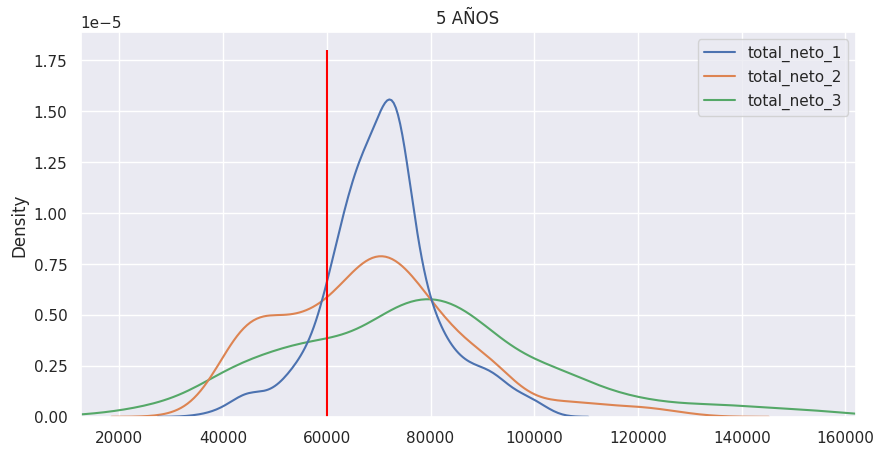

,perc_max_0,coste_ac_1,total_neto_1,total_neto_2,total_neto_3
count,128.000000,128.0,128.000000,128.000000,128.000000
mean,0.707401,60000.0,67865.218750,67721.515625,74214.984375
std,0.076425,0.0,11629.649092,17461.621287,26445.040243
min,0.474441,60000.0,35810.000000,32500.000000,12512.000000
25%,0.662816,60000.0,61050.250000,55039.000000,58399.250000
50%,0.733521,60000.0,70267.000000,66687.000000,74738.500000
75%,0.764134,60000.0,75036.500000,78293.000000,90798.500000
max,0.798535,60000.0,91605.000000,120289.000000,146239.000000


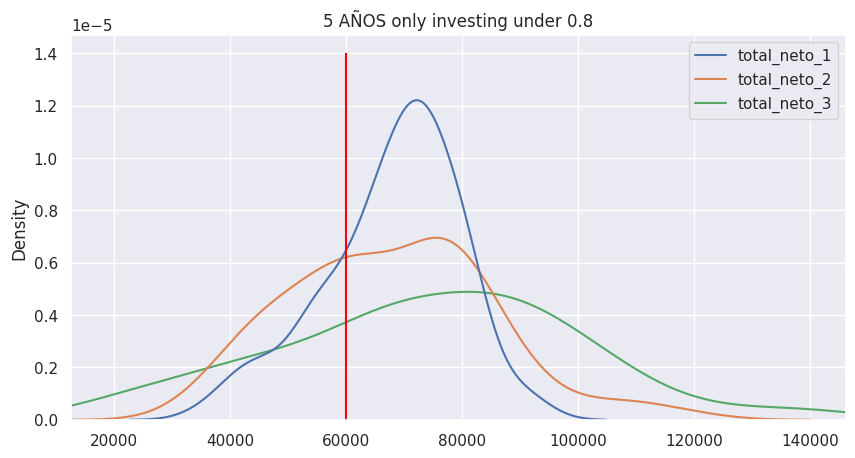

,perc_max_0,coste_ac_1,total_neto_1,total_neto_2,total_neto_3
count,46.000000,46.0,46.000000,46.000000,46.000000
mean,0.620733,60000.0,71454.934783,75360.239130,84804.695652
std,0.056273,0.0,8620.450461,13050.138121,19619.622079
min,0.474441,60000.0,46038.000000,45583.000000,34032.000000
25%,0.581322,60000.0,65380.750000,66556.500000,70143.250000
50%,0.625628,60000.0,72061.000000,74787.000000,85001.500000
75%,0.667893,60000.0,79831.500000,84827.250000,102033.500000
max,0.698302,60000.0,83327.000000,104426.000000,120733.000000


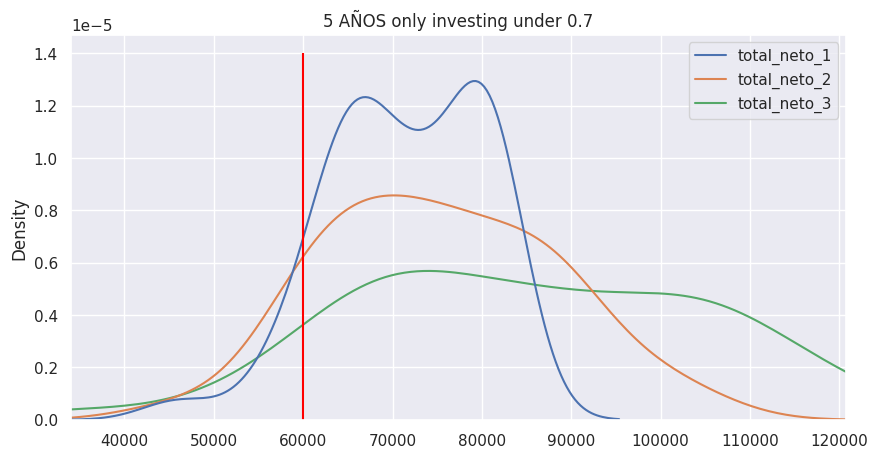

,perc_max_0,coste_ac_1,total_neto_1,total_neto_2,total_neto_3
count,771.000000,771.0,771.000000,771.000000,771.000000
mean,0.904840,120000.0,166968.573281,164991.011673,183551.691310
std,0.108845,0.0,36629.272965,41087.211315,62023.056633
min,0.474441,120000.0,74494.000000,64264.000000,40531.000000
25%,0.844291,120000.0,139628.000000,135149.500000,138030.500000
50%,0.946517,120000.0,167463.000000,159316.000000,174821.000000
75%,0.998693,120000.0,189748.000000,193441.000000,225991.500000
max,1.000000,120000.0,279728.000000,290187.000000,372846.000000


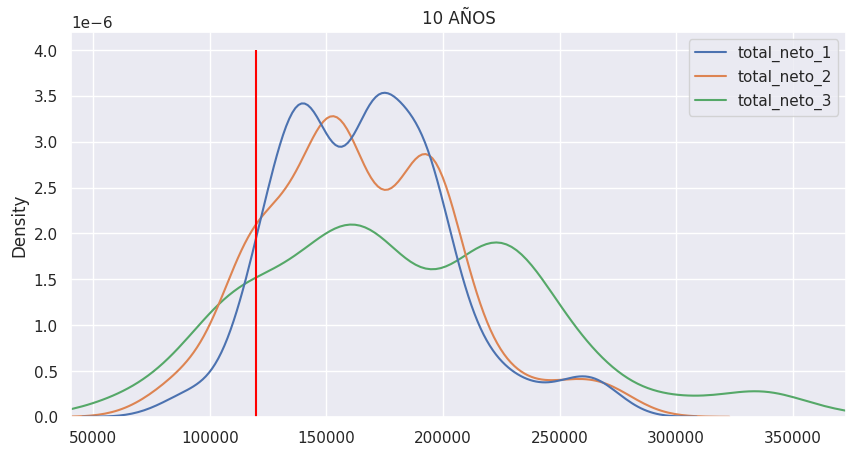

,perc_max_0,coste_ac_1,total_neto_1,total_neto_2,total_neto_3
count,128.000000,128.0,128.000000,128.000000,128.000000
mean,0.707401,120000.0,171245.945312,172140.242188,189848.914062
std,0.076425,0.0,30096.491824,37620.921887,56208.463497
min,0.474441,120000.0,119789.000000,110531.000000,102036.000000
25%,0.662816,120000.0,146256.500000,150979.250000,150446.000000
50%,0.733521,120000.0,169348.000000,158958.500000,173606.000000
75%,0.764134,120000.0,187215.500000,195288.000000,226784.000000
max,0.798535,120000.0,261663.000000,274329.000000,340683.000000


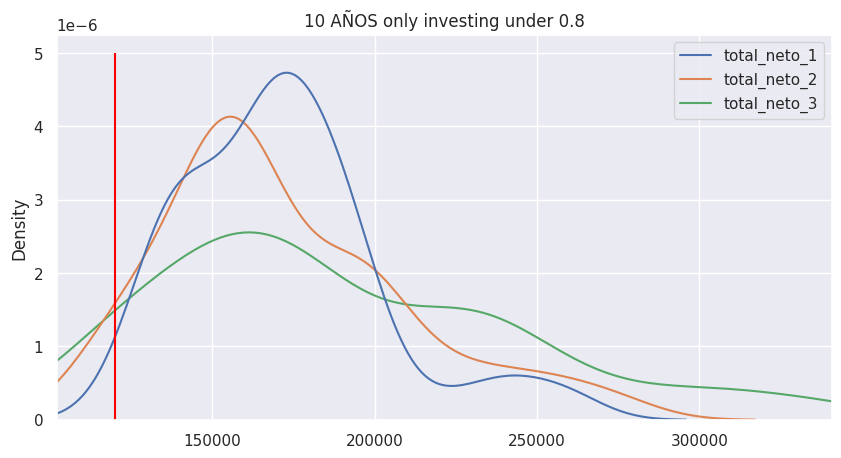

,perc_max_0,coste_ac_1,total_neto_1,total_neto_2,total_neto_3
count,46.000000,46.0,46.000000,46.000000,46.000000
mean,0.620733,120000.0,164005.021739,170613.717391,184604.652174
std,0.056273,0.0,23650.880074,30658.791029,47709.627698
min,0.474441,120000.0,119789.000000,110531.000000,102036.000000
25%,0.581322,120000.0,144801.250000,150919.000000,148781.250000
50%,0.625628,120000.0,161219.000000,162429.500000,176394.500000
75%,0.667893,120000.0,185240.750000,196088.250000,228795.500000
max,0.698302,120000.0,232413.000000,254145.000000,306426.000000


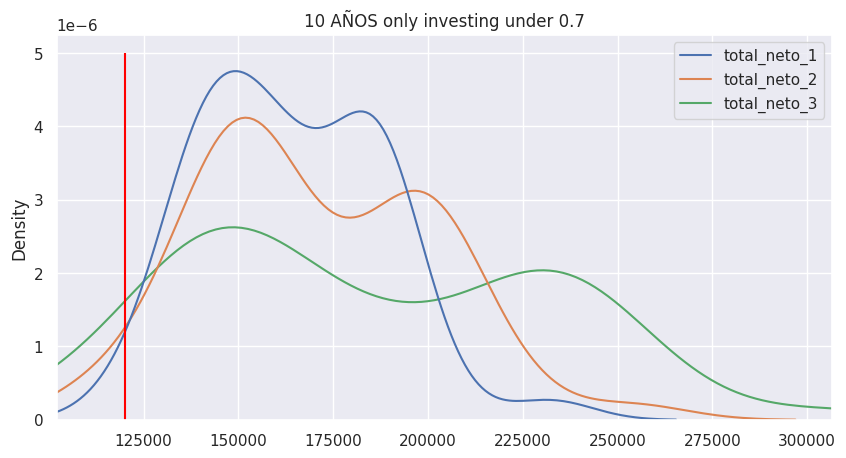

,perc_max_0,coste_ac_1,total_neto_1,total_neto_2,total_neto_3
count,711.000000,711.0,711.000000,711.000000,711.000000
mean,0.910735,180000.0,299828.654008,296241.067511,328743.473980
std,0.105302,0.0,87528.532003,93378.759250,131039.142795
min,0.474441,180000.0,139365.000000,136748.000000,121871.000000
25%,0.851782,180000.0,231918.000000,225407.000000,222383.000000
50%,0.951608,180000.0,285787.000000,286410.000000,322366.000000
75%,0.999750,180000.0,354794.500000,344070.000000,408252.500000
max,1.000000,180000.0,563006.000000,637508.000000,776913.000000


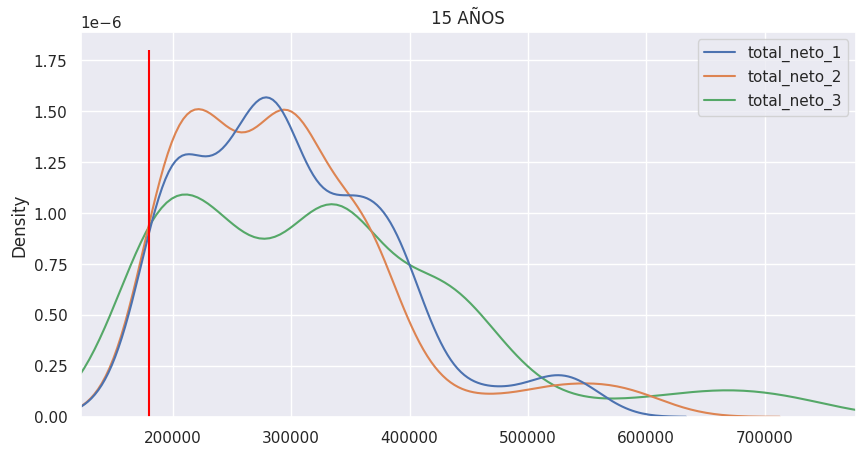

,perc_max_0,coste_ac_1,total_neto_1,total_neto_2,total_neto_3
count,106.000000,106.0,106.000000,106.000000,106.000000
mean,0.710010,180000.0,322627.792453,322304.377358,357117.905660
std,0.079419,0.0,53359.575570,66183.225118,92616.363904
min,0.474441,180000.0,190642.000000,198385.000000,185393.000000
25%,0.658228,180000.0,285133.250000,278670.000000,298578.250000
50%,0.739432,180000.0,311163.500000,306484.500000,325213.000000
75%,0.767451,180000.0,369311.250000,359519.750000,420952.500000
max,0.798535,180000.0,472248.000000,560255.000000,669401.000000


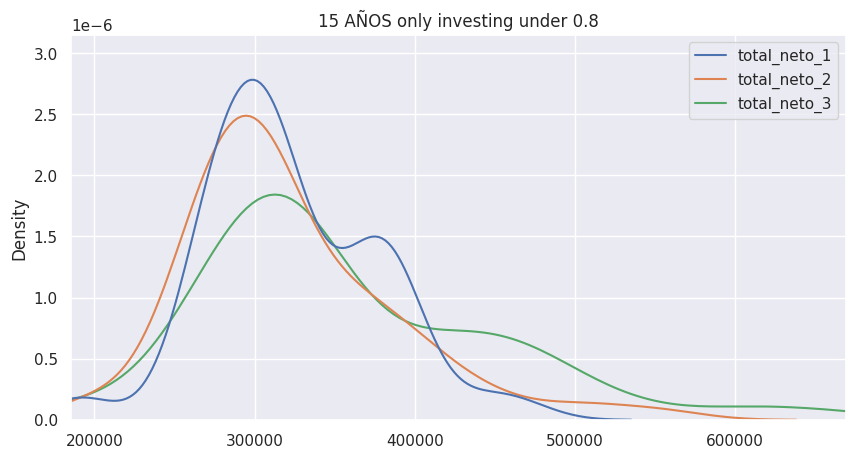

,perc_max_0,coste_ac_1,total_neto_1,total_neto_2,total_neto_3
count,36.000000,36.0,36.000000,36.000000,36.000000
mean,0.614476,180000.0,334054.166667,344577.944444,379536.805556
std,0.058080,0.0,42764.103324,54254.032424,80161.605129
min,0.474441,180000.0,274479.000000,260452.000000,269172.000000
25%,0.579398,180000.0,301936.000000,307730.750000,320691.500000
50%,0.614058,180000.0,314894.500000,323777.000000,338733.000000
75%,0.658228,180000.0,378010.750000,390439.250000,462404.000000
max,0.698302,180000.0,406970.000000,452526.000000,533339.000000


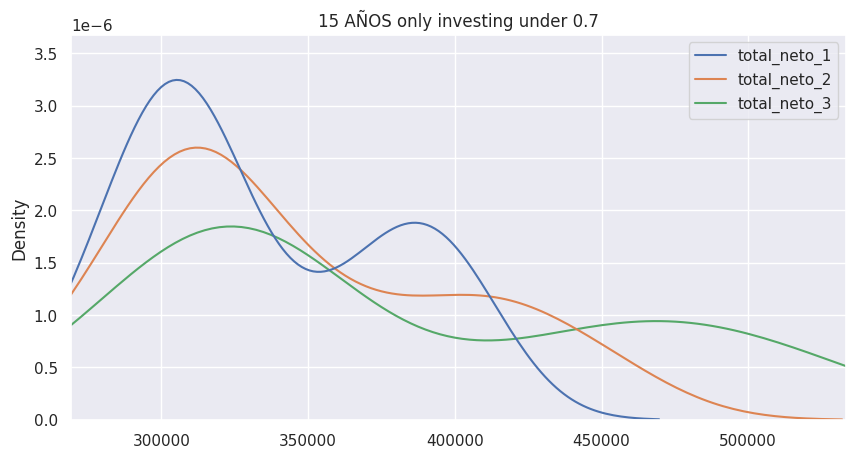

,perc_max_0,coste_ac_1,total_neto_1,total_neto_2,total_neto_3
count,651.000000,651.0,6.510000e+02,6.510000e+02,6.510000e+02
mean,0.919072,240000.0,4.825251e+05,4.787218e+05,5.293274e+05
std,0.099990,0.0,1.799358e+05,1.766585e+05,2.416160e+05
min,0.537188,240000.0,2.250700e+05,2.379840e+05,2.281150e+05
25%,0.868018,240000.0,3.504175e+05,3.506875e+05,3.648015e+05
50%,0.960337,240000.0,4.430000e+05,4.380500e+05,4.637960e+05
75%,1.000000,240000.0,5.652920e+05,5.494870e+05,6.088875e+05
max,1.000000,240000.0,1.080887e+06,1.108691e+06,1.390261e+06


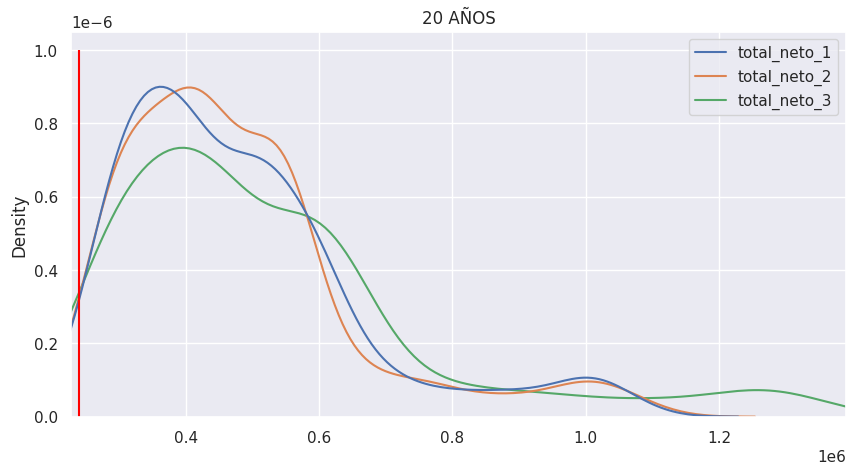

,perc_max_0,coste_ac_1,total_neto_1,total_neto_2,total_neto_3
count,83.000000,83.0,83.000000,83.000000,8.300000e+01
mean,0.710820,240000.0,576324.325301,576871.301205,6.471218e+05
std,0.073279,0.0,112416.433915,114833.806819,1.616237e+05
min,0.537188,240000.0,278417.000000,287847.000000,2.707980e+05
25%,0.660212,240000.0,523080.000000,533092.000000,5.722990e+05
50%,0.739348,240000.0,575671.000000,561285.000000,6.127260e+05
75%,0.764778,240000.0,606109.500000,595527.000000,6.834905e+05
max,0.798080,240000.0,950571.000000,971706.000000,1.199623e+06


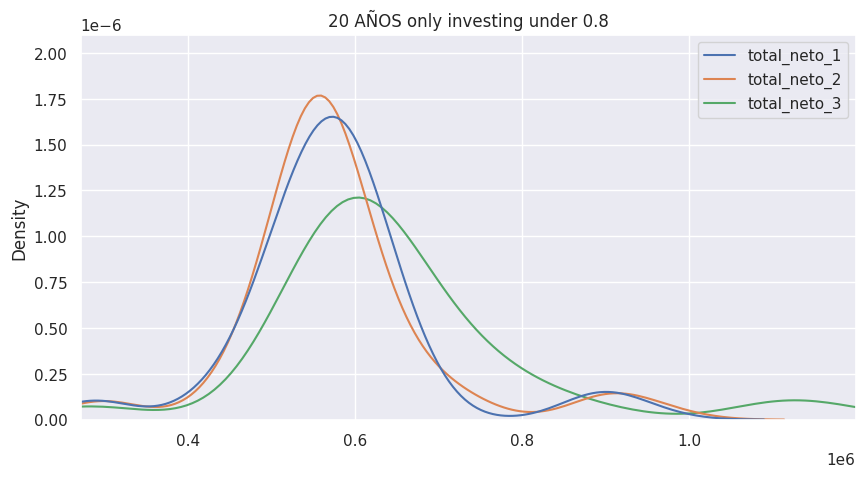

,perc_max_0,coste_ac_1,total_neto_1,total_neto_2,total_neto_3
count,30.000000,30.0,30.000000,30.000000,30.000000
mean,0.627067,240000.0,547379.033333,556705.800000,607263.800000
std,0.050773,0.0,36128.629395,37075.773592,60104.555368
min,0.537188,240000.0,476151.000000,486554.000000,511773.000000
25%,0.585899,240000.0,522508.250000,532688.500000,562002.250000
50%,0.630458,240000.0,548333.000000,553089.000000,588968.000000
75%,0.669320,240000.0,577470.750000,575360.750000,654535.250000
max,0.698302,240000.0,619360.000000,655282.000000,749846.000000


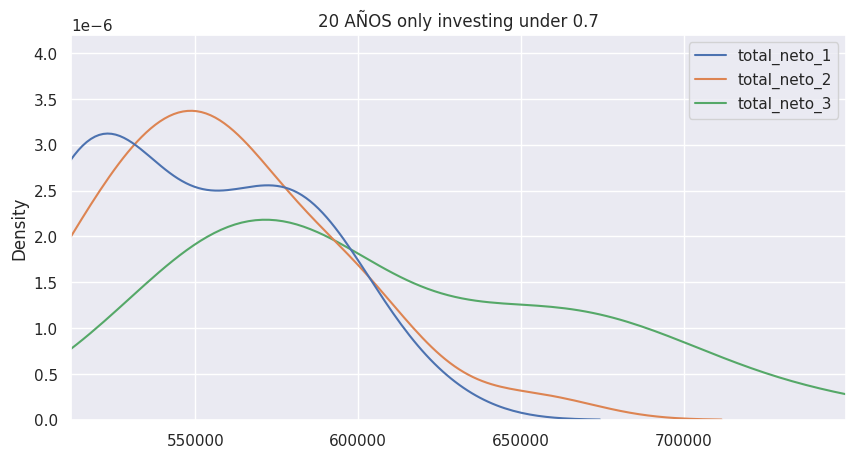

,perc_max_0,coste_ac_1,total_neto_1,total_neto_2,total_neto_3
count,591.000000,591.0,5.910000e+02,5.910000e+02,5.910000e+02
mean,0.932403,300000.0,7.511516e+05,7.454137e+05,8.251027e+05
std,0.082997,0.0,3.084952e+05,2.877286e+05,3.689088e+05
min,0.538247,300000.0,3.713550e+05,3.697110e+05,3.604870e+05
25%,0.883918,300000.0,5.300955e+05,5.375945e+05,5.914795e+05
50%,0.966177,300000.0,6.605350e+05,6.750540e+05,7.203560e+05
75%,1.000000,300000.0,8.669600e+05,8.700765e+05,9.952490e+05
max,1.000000,300000.0,1.796664e+06,1.824107e+06,2.181949e+06


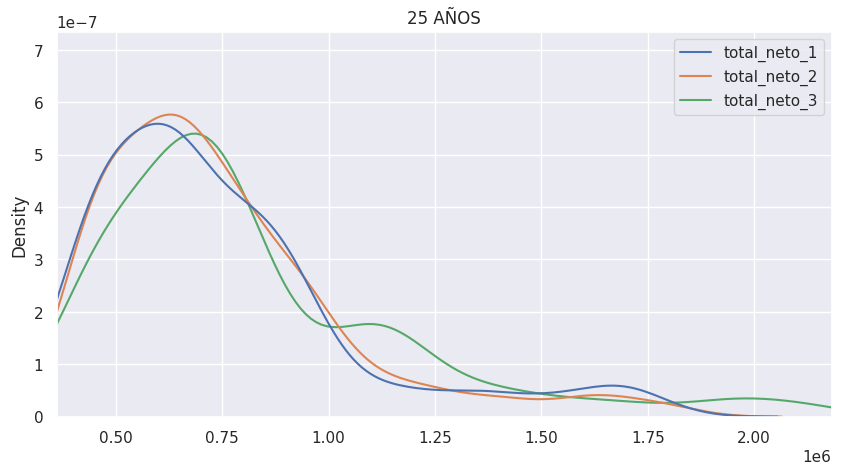

,perc_max_0,coste_ac_1,total_neto_1,total_neto_2,total_neto_3
count,49.000000,49.0,4.900000e+01,4.900000e+01,4.900000e+01
mean,0.736439,300000.0,1.175236e+06,1.183433e+06,1.385042e+06
std,0.061951,0.0,4.670116e+05,4.512312e+05,5.721142e+05
min,0.538247,300000.0,5.494590e+05,5.640810e+05,6.299260e+05
25%,0.710462,300000.0,8.200380e+05,8.332320e+05,9.147040e+05
50%,0.755697,300000.0,9.385050e+05,9.972810e+05,1.189912e+06
75%,0.780031,300000.0,1.691122e+06,1.653555e+06,1.974726e+06
max,0.796755,300000.0,1.796664e+06,1.824107e+06,2.181949e+06


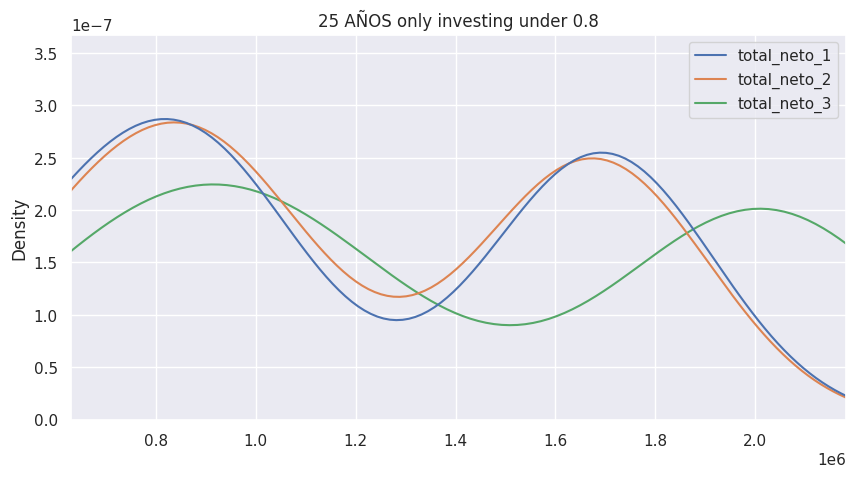

,perc_max_0,coste_ac_1,total_neto_1,total_neto_2,total_neto_3
count,10.000000,10.0,1.000000e+01,1.000000e+01,1.000000e+01
mean,0.633333,300000.0,1.513438e+06,1.558971e+06,1.841532e+06
std,0.052512,0.0,4.239679e+05,4.344962e+05,5.455840e+05
min,0.538247,300000.0,5.523250e+05,5.871560e+05,6.543940e+05
25%,0.597332,300000.0,1.632272e+06,1.661928e+06,1.980954e+06
50%,0.639051,300000.0,1.698010e+06,1.743978e+06,2.084492e+06
75%,0.671634,300000.0,1.713132e+06,1.811140e+06,2.139915e+06
max,0.698302,300000.0,1.796664e+06,1.824107e+06,2.181949e+06


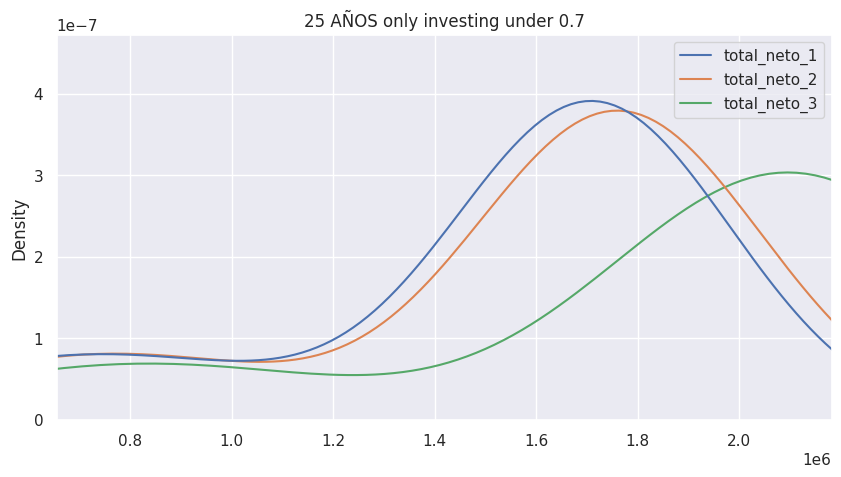

In [422]:
coste_anual_deseado = 12000
dic_all = {}
for años_i in [5, 10, 15, 20, 25]:
  df_all_sim = perform_sim(años_i, coste_anual_deseado)
  dic_all[años_i] = df_all_sim
  plot_results(años_i, df_all_sim[['Date_0', 'Date_n', 'perc_max_0', 'coste_ac_1', 'total_neto_1', 'total_neto_2', 'total_neto_3']])

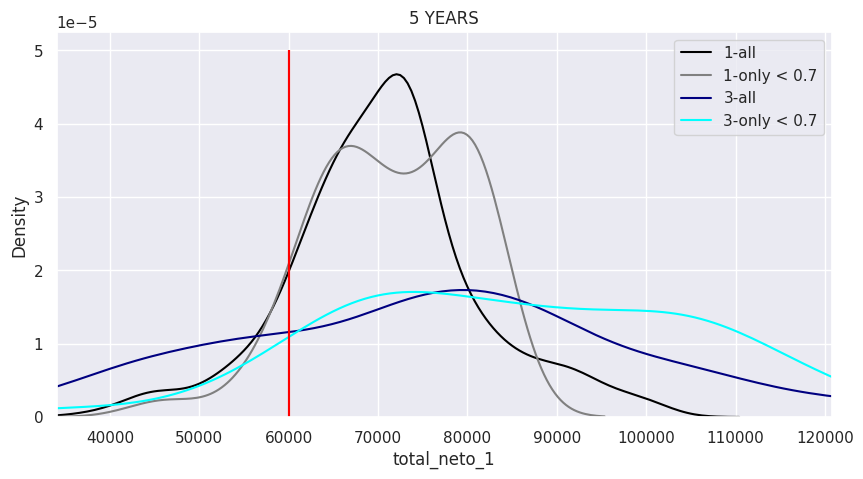

In [437]:
años = 5
plt.rcParams["figure.figsize"] = (10,5)
df_ii = dic_all[años]
filter_i = df_ii["perc_max_0"] < 0.7
df_iii = df_ii[filter_i]
p = sns.kdeplot(data=df_ii["total_neto_1"], label = "1-all", color="black")
p = sns.kdeplot(data=df_iii["total_neto_1"], label = "1-only < 0.7", color="grey")
p = sns.kdeplot(data=df_ii["total_neto_3"], label = "3-all", color="navy")
p = sns.kdeplot(data=df_iii["total_neto_3"], label = "3-only < 0.7", color="aqua")
ticks = max(p.get_yticks())  # get the max value of the y-ticks
p.vlines(x=np.mean(df_ii["coste_ac_1"].iloc[-1]) , ymin=0, ymax=ticks, color='red')
p.vlines(x=np.mean(df_iii["coste_ac_1"].iloc[-1]) , ymin=0, ymax=ticks, color='red')
plt.xlim(left=min(min(df_iii["total_neto_1"]),min(df_iii["total_neto_3"])), right=max(df_iii["total_neto_3"]))
plt.title(str(años)+" YEARS")
plt.legend()
plt.show()


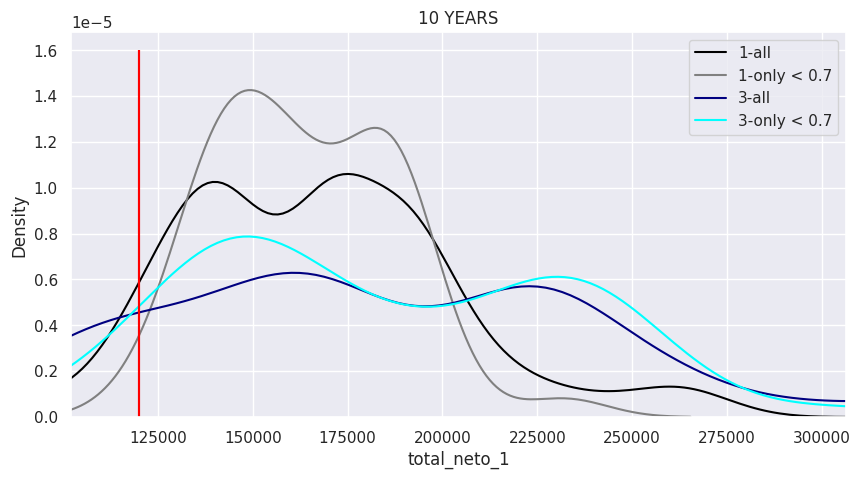

In [438]:
años = 10
plt.rcParams["figure.figsize"] = (10,5)
df_ii = dic_all[años]
filter_i = df_ii["perc_max_0"] < 0.7
df_iii = df_ii[filter_i]
p = sns.kdeplot(data=df_ii["total_neto_1"], label = "1-all", color="black")
p = sns.kdeplot(data=df_iii["total_neto_1"], label = "1-only < 0.7", color="grey")
p = sns.kdeplot(data=df_ii["total_neto_3"], label = "3-all", color="navy")
p = sns.kdeplot(data=df_iii["total_neto_3"], label = "3-only < 0.7", color="aqua")
ticks = max(p.get_yticks())  # get the max value of the y-ticks
p.vlines(x=np.mean(df_ii["coste_ac_1"].iloc[-1]) , ymin=0, ymax=ticks, color='red')
p.vlines(x=np.mean(df_iii["coste_ac_1"].iloc[-1]) , ymin=0, ymax=ticks, color='red')
plt.xlim(left=min(min(df_iii["total_neto_1"]),min(df_iii["total_neto_3"])), right=max(df_iii["total_neto_3"]))
plt.title(str(años)+" YEARS")
plt.legend()
plt.show()

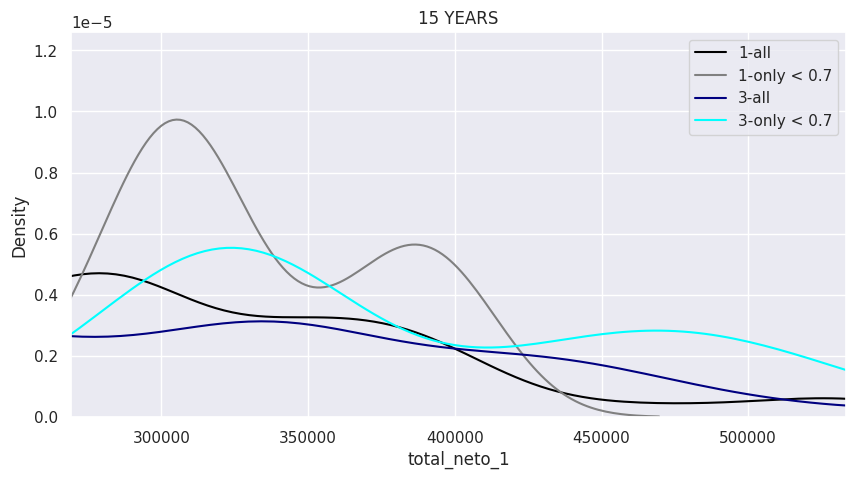

In [439]:
años = 15
plt.rcParams["figure.figsize"] = (10,5)
df_ii = dic_all[años]
filter_i = df_ii["perc_max_0"] < 0.7
df_iii = df_ii[filter_i]
p = sns.kdeplot(data=df_ii["total_neto_1"], label = "1-all", color="black")
p = sns.kdeplot(data=df_iii["total_neto_1"], label = "1-only < 0.7", color="grey")
p = sns.kdeplot(data=df_ii["total_neto_3"], label = "3-all", color="navy")
p = sns.kdeplot(data=df_iii["total_neto_3"], label = "3-only < 0.7", color="aqua")
ticks = max(p.get_yticks())  # get the max value of the y-ticks
p.vlines(x=np.mean(df_ii["coste_ac_1"].iloc[-1]) , ymin=0, ymax=ticks, color='red')
p.vlines(x=np.mean(df_iii["coste_ac_1"].iloc[-1]) , ymin=0, ymax=ticks, color='red')
plt.xlim(left=min(min(df_iii["total_neto_1"]),min(df_iii["total_neto_3"])), right=max(df_iii["total_neto_3"]))
plt.title(str(años)+" YEARS")
plt.legend()
plt.show()

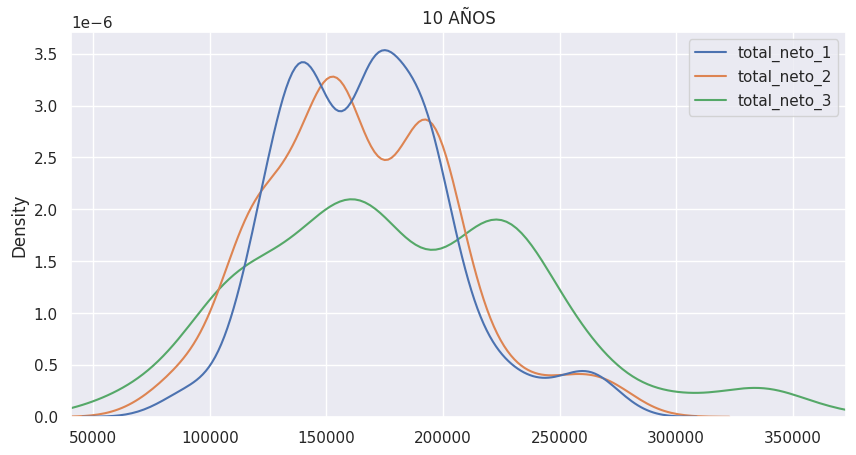

,perc_max_0,total_neto_1,total_neto_2,total_neto_3
count,771.000000,771.000000,771.000000,771.000000
mean,0.904840,166968.573281,164991.011673,183552.160190
std,0.108845,36629.272965,41087.211315,62023.056633
min,0.474441,74494.000000,64264.000000,40531.468880
25%,0.844291,139628.000000,135149.500000,138030.968880
50%,0.946517,167463.000000,159316.000000,174821.468880
75%,0.998693,189748.000000,193441.000000,225991.968880
max,1.000000,279728.000000,290187.000000,372846.468880


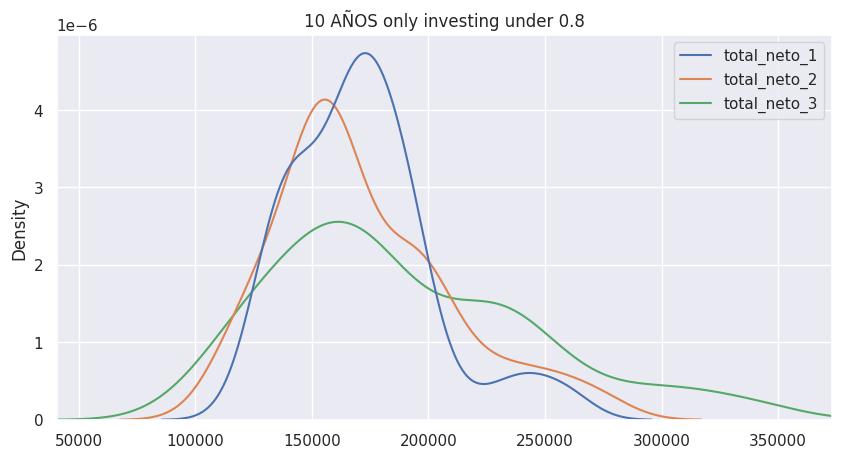

,perc_max_0,total_neto_1,total_neto_2,total_neto_3
count,128.000000,128.000000,128.000000,128.000000
mean,0.707401,171245.945312,172140.242188,189849.382942
std,0.076425,30096.491824,37620.921887,56208.463497
min,0.474441,119789.000000,110531.000000,102036.468880
25%,0.662816,146256.500000,150979.250000,150446.468880
50%,0.733521,169348.000000,158958.500000,173606.468880
75%,0.764134,187215.500000,195288.000000,226784.468880
max,0.798535,261663.000000,274329.000000,340683.468880


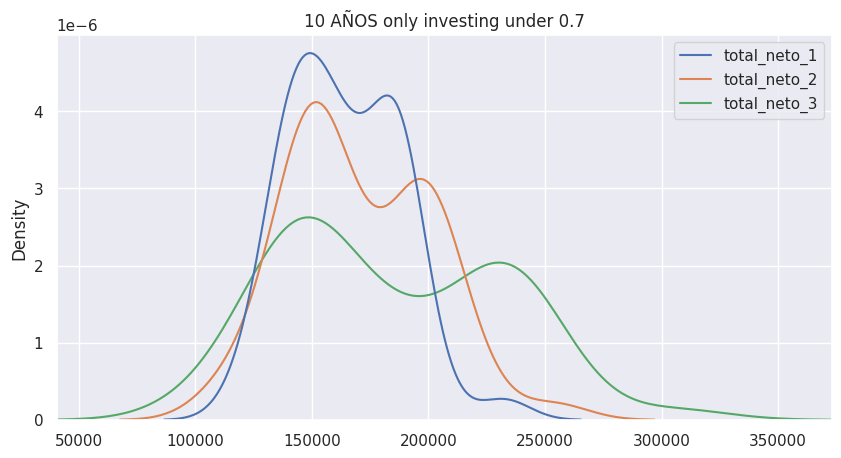

,perc_max_0,total_neto_1,total_neto_2,total_neto_3
count,46.000000,46.000000,46.000000,46.000000
mean,0.620733,164005.021739,170613.717391,184605.121054
std,0.056273,23650.880074,30658.791029,47709.627698
min,0.474441,119789.000000,110531.000000,102036.468880
25%,0.581322,144801.250000,150919.000000,148781.718880
50%,0.625628,161219.000000,162429.500000,176394.968880
75%,0.667893,185240.750000,196088.250000,228795.968880
max,0.698302,232413.000000,254145.000000,306426.468880


In [405]:
plt.rcParams["figure.figsize"] = (10,5)
sns.kdeplot(data=df_ii[["total_neto_1","total_neto_2","total_neto_3"]])
plt.xlim(left=min(df_ii["total_neto_3"]), right=max(df_ii["total_neto_3"]))
plt.title("10 AÑOS")
plt.show()
display(df_ii.describe())
print()

filter_i = df_ii["perc_max_0"] < 0.8
df_iii = df_ii[filter_i]
plt.rcParams["figure.figsize"] = (10,5)
sns.kdeplot(data=df_iii[["total_neto_1","total_neto_2","total_neto_3"]])
plt.xlim(left=min(df_ii["total_neto_3"]), right=max(df_ii["total_neto_3"]))
plt.title("10 AÑOS only investing under 0.8")
plt.show()
display(df_iii.describe())
print()

filter_i = df_ii["perc_max_0"] < 0.7
df_iii = df_ii[filter_i]
plt.rcParams["figure.figsize"] = (10,5)
sns.kdeplot(data=df_iii[["total_neto_1","total_neto_2","total_neto_3"]])
plt.xlim(left=min(df_ii["total_neto_3"]), right=max(df_ii["total_neto_3"]))
plt.title("10 AÑOS only investing under 0.7")
plt.show()
display(df_iii.describe())
print()

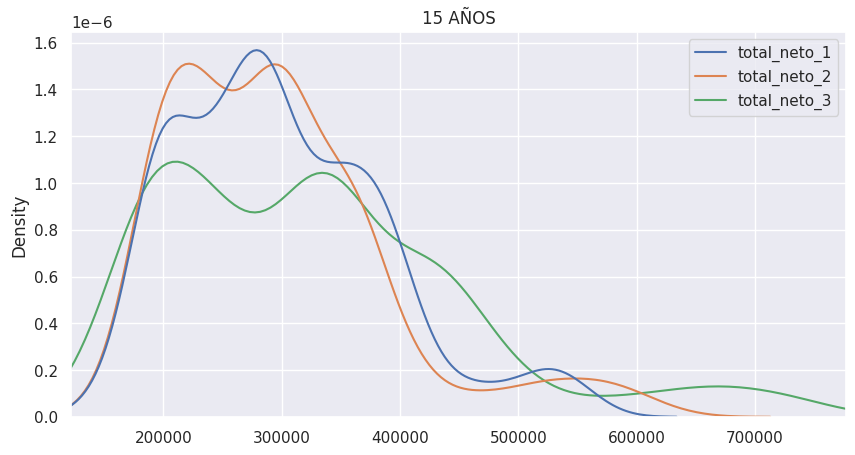

,perc_max_0,total_neto_1,total_neto_2,total_neto_3
count,711.000000,711.000000,711.000000,711.000000
mean,0.910735,299828.654008,296241.067511,328743.473980
std,0.105302,87528.532003,93378.759250,131039.142795
min,0.474441,139365.000000,136748.000000,121871.000000
25%,0.851782,231918.000000,225407.000000,222383.000000
50%,0.951608,285787.000000,286410.000000,322366.000000
75%,0.999750,354794.500000,344070.000000,408252.500000
max,1.000000,563006.000000,637508.000000,776913.000000


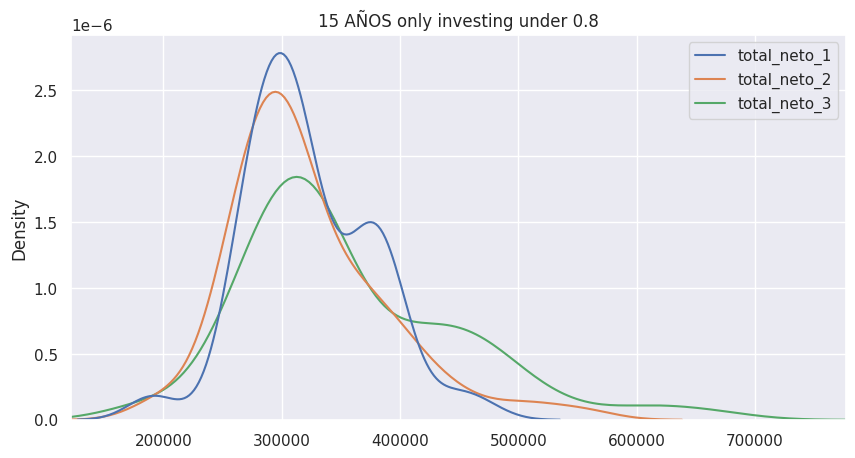

,perc_max_0,total_neto_1,total_neto_2,total_neto_3
count,106.000000,106.000000,106.000000,106.000000
mean,0.710010,322627.792453,322304.377358,357117.905660
std,0.079419,53359.575570,66183.225118,92616.363904
min,0.474441,190642.000000,198385.000000,185393.000000
25%,0.658228,285133.250000,278670.000000,298578.250000
50%,0.739432,311163.500000,306484.500000,325213.000000
75%,0.767451,369311.250000,359519.750000,420952.500000
max,0.798535,472248.000000,560255.000000,669401.000000


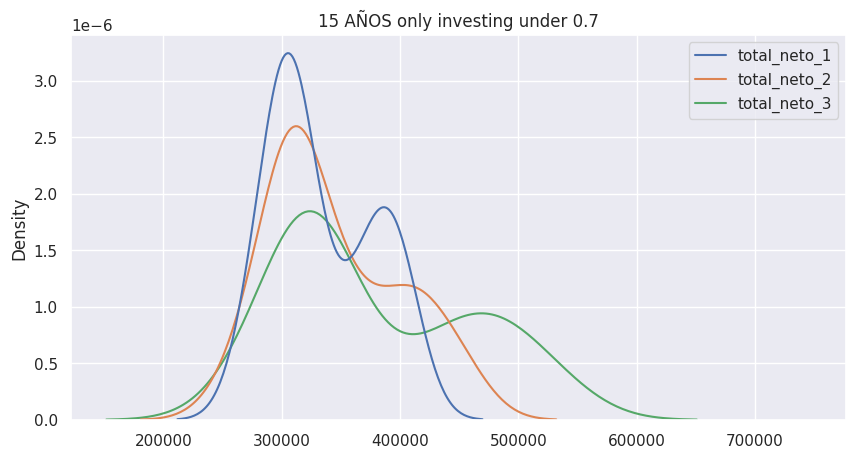

,perc_max_0,total_neto_1,total_neto_2,total_neto_3
count,36.000000,36.000000,36.000000,36.000000
mean,0.614476,334054.166667,344577.944444,379536.805556
std,0.058080,42764.103324,54254.032424,80161.605129
min,0.474441,274479.000000,260452.000000,269172.000000
25%,0.579398,301936.000000,307730.750000,320691.500000
50%,0.614058,314894.500000,323777.000000,338733.000000
75%,0.658228,378010.750000,390439.250000,462404.000000
max,0.698302,406970.000000,452526.000000,533339.000000


In [411]:
plt.rcParams["figure.figsize"] = (10,5)
sns.kdeplot(data=df_ii[["total_neto_1","total_neto_2","total_neto_3"]])
plt.xlim(left=min(df_ii["total_neto_3"]), right=max(df_ii["total_neto_3"]))
plt.title("15 AÑOS")
plt.show()
display(df_ii.describe())
print()

filter_i = df_ii["perc_max_0"] < 0.8
df_iii = df_ii[filter_i]
plt.rcParams["figure.figsize"] = (10,5)
sns.kdeplot(data=df_iii[["total_neto_1","total_neto_2","total_neto_3"]])
plt.xlim(left=min(df_ii["total_neto_3"]), right=max(df_ii["total_neto_3"]))
plt.title("15 AÑOS only investing under 0.8")
plt.show()
display(df_iii.describe())
print()

filter_i = df_ii["perc_max_0"] < 0.7
df_iii = df_ii[filter_i]
plt.rcParams["figure.figsize"] = (10,5)
sns.kdeplot(data=df_iii[["total_neto_1","total_neto_2","total_neto_3"]])
plt.xlim(left=min(df_ii["total_neto_3"]), right=max(df_ii["total_neto_3"]))
plt.title("15 AÑOS only investing under 0.7")
plt.show()
display(df_iii.describe())
print()